In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import json
import matplotlib
import os
import random
import torch

from collections import Counter, defaultdict
from itertools import islice
from sklearn.utils import shuffle
from tqdm import tqdm, trange
from torch.optim import Adam
from torch.utils.data import TensorDataset

from models.Encoder import *
from models.Decoder import *
from models.utils import *
from utils import *

# set fixed random seed to reproduce results
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

%matplotlib inline

GPU is available
GPU is available


Using TensorFlow backend.


# Experiment 2

In [2]:
# define experiment
exp='/exp_2'

# define number of iterations
n_iters = 20000

# define batch size
batch_size = 32

In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# load dataset into memory, and get w2idx, idx2w, w2freq dictionaries and lists of input and output sentences
cmd_vocab, w2i_cmds, i2w_cmds, cmds_train, act_vocab, w2i_acts, i2w_acts, acts_train = load_dataset(exp=exp, split='/train')
_, _, _, cmds_test, _, _, _, acts_test = load_dataset(exp=exp, split='/test')

In [5]:
## create input and output language pairs ##

# training
train_cmd_act_pairs = create_pairs(cmds_train, acts_train)
print("Number of train source-target pairs: {}".format(len(train_cmd_act_pairs)))

# testing
test_cmd_act_pairs = create_pairs(cmds_test, acts_test)
print("Number of test source-target pairs: {}".format(len(test_cmd_act_pairs)))

Number of train source-target pairs: 16990
Number of test source-target pairs: 3920


In [6]:
# show random train command-action pair
random_pair = random.choice(train_cmd_act_pairs)
print("Command: {}".format(random_pair[0]))
print("Action: {}".format(random_pair[1]))

Command: ['jump', 'opposite', 'left', 'after', 'run', 'thrice']
Action: ['I_RUN', 'I_RUN', 'I_RUN', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_JUMP']


In [7]:
# show random test command-action pair
random_pair = random.choice(test_cmd_act_pairs)
print("Command: {}".format(random_pair[0]))
print("Action: {}".format(random_pair[1]))

Command: ['run', 'around', 'right', 'twice', 'and', 'look', 'around', 'right']
Action: ['I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_LOOK', 'I_TURN_RIGHT', 'I_LOOK', 'I_TURN_RIGHT', 'I_LOOK', 'I_TURN_RIGHT', 'I_LOOK']


## Prepare data

In [8]:
cmds_train, acts_train, input_lengths_train, masks = pairs2idx(cmds_train, acts_train, w2i_cmds, w2i_acts, padding=True, training=True)
cmds_test, acts_test, input_lengths_test = pairs2idx(cmds_test, acts_test, w2i_cmds, w2i_acts, padding=True, training=False)

In [9]:
# create train and test data loaders
train_dl = create_batches(cmds_train, acts_train, input_lengths_train, batch_size=batch_size, masks=masks, split='train', num_samples=n_iters)
test_dl = create_batches(cmds_test, acts_test, input_lengths_test, batch_size=batch_size, split='test')

In [10]:
### Hyperparameters for training ###

# source language (i.e., commands) vocabulary size |V_source|
in_size = len(w2i_cmds)

# target language (i.e., actions) vocabulary size |V_target|
out_size = len(w2i_acts)

# size of word embeddings
emb_size = 20 #[10, 20]

# size of hidden units
hidden_size = 50 #[50, 100]

# number of layers
layer_size = 1 #[1, 2]

# layer dropout rates
dropout_rate = 0.5 #[0.25, 0.5]

# learning rate
lr = 1e-3

# define whether encoder is uni- or bidirectional (decoder cannot be bidirectional)
bidir = False

# number of epochs
n_epochs = 10 # 10-15 epochs (20.000 iterations each) seem to be sufficient to let models converge (find local minima)

## Grid search over specified hyperparameter space

In [11]:
def grid_search(embedding_sizes:list, hidden_sizes:list, layer_sizes:list, dropout_rates:list, lr:float, n_epochs:int):
    in_size = len(w2i_cmds) # source language (i.e., commands) vocabulary size |V_source|
    out_size = len(w2i_acts) # target language (i.e., actions) vocabulary size |V_target|
    batch_size = 32
    grid_results = defaultdict(dict)
    for emb_size in embedding_sizes:
        for hidden_size in hidden_sizes:
            for layer_size in layer_sizes:
                for dropout_rate in dropout_rates:
                    # instantiate models
                    encoder = EncoderGRU(in_size, emb_size, hidden_size, layer_size, dropout=dropout_rate, bidir=False)
                    decoder = DecoderGRU(emb_size, hidden_size, out_size, layer_size, dropout=dropout_rate)
                    # move models to GPU, if nvidia GPU is available (faster computation)
                    encoder.cuda()
                    decoder.cuda()
                    train_losses, train_accs, encoder, decoder = train(train_dl, w2i_cmds, w2i_acts, i2w_cmds, i2w_acts,
                                                                       encoder, decoder, epochs=n_epochs,
                                                                       batch_size=batch_size, learning_rate=lr)
                    test_acc = test(test_dl, w2i_cmds, w2i_acts, i2w_cmds, i2w_acts, encoder, decoder, batch_size=batch_size)
                    grid_results[(emb_size, hidden_size, layer_size, dropout_rate)]['train_accs'] = train_accs
                    grid_results[(emb_size, hidden_size, layer_size, dropout_rate)]['train_losses'] = train_losses
                    grid_results[(emb_size, hidden_size, layer_size, dropout_rate)]['test_acc'] = test_acc
    return grid_results

## Debugging

In [12]:
## Instantiate models ##

encoder = EncoderGRU(in_size, emb_size, hidden_size, layer_size, dropout=dropout_rate, bidir=bidir)
decoder = AttnDecoderGRU(emb_size, hidden_size, out_size, layer_size, dropout=dropout_rate)

C:\Users\lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [13]:
encoder.cuda()

EncoderGRU(
  (embedding): Embedding(16, 20, padding_idx=0)
  (gru): GRU(20, 50, batch_first=True, dropout=0.5)
)

In [14]:
# move models to GPU, if GPU is available (for faster computation)
decoder.cuda()

AttnDecoderGRU(
  (embedding): Embedding(9, 20, padding_idx=0)
  (attention): MultiplicativeAttention(
    (attn): Linear(in_features=50, out_features=50, bias=True)
  )
  (gru): GRU(20, 50, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=100, out_features=9, bias=True)
)

### Training

In [ ]:
train_losses, train_accs, encoder, decoder = train(train_dl,
                                                   w2i_cmds, w2i_acts,
                                                   i2w_cmds, i2w_acts,
                                                   encoder, decoder,
                                                   epochs=n_epochs,
                                                   batch_size=batch_size,
                                                   learning_rate=lr,
                                                   detailed_analysis=True)

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 0.6459187046319497
Acc: 0.0012458471760797341

Command: walk opposite left twice and turn around right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS> <EOS> <EOS>

True sent length: 19
Pred sent length: 19

Loss: 0.30377136456439185
Acc: 0.035617720465890186

Command: run opposite right twice and walk around left twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN

Epoch:  10%|███████▌                                                                   | 1/10 [02:41<24:15, 161.72s/it]

Loss: 0.20356826816432394
Acc: 0.27232142857142855

Command: jump opposite left twice and look opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>

True sent length: 13
Pred sent length: 13



### Testing

In [27]:
test_acc, results_cmds, results_acts = test(test_dl,
                                            w2i_cmds, w2i_acts, 
                                            i2w_cmds, i2w_acts, 
                                            encoder, decoder,
                                            batch_size=batch_size,
                                            detailed_analysis=True,
                                            detailed_results=True)

Current test acc: 0.049019607843137254

Command: run around left thrice after run opposite right <EOS> <PAD>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>

True sent length: 28
Pred sent length: 28

Current test acc: 0.024752475247524754

Command: walk around left twice after walk around left twice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_

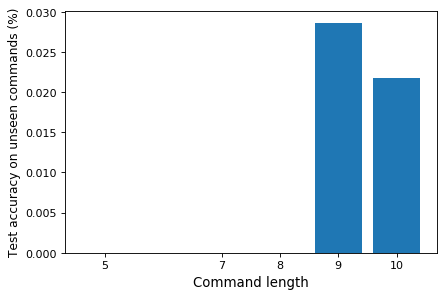

<Figure size 432x288 with 0 Axes>

In [40]:
cmd_lengths, cmd_accs = zip(*results_cmds.items())
plt.figure(figsize=(6, 4), dpi=80)
plt.bar(cmd_lengths, cmd_accs)
plt.xlabel('Command length', fontsize=12)
plt.ylabel('Test accuracy on unseen commands (%)', fontsize=11)
plt.xticks(ticks=cmd_lengths)
plt.savefig('./paper/plots/experiment_2_commands.png')
plt.show()
plt.clf()

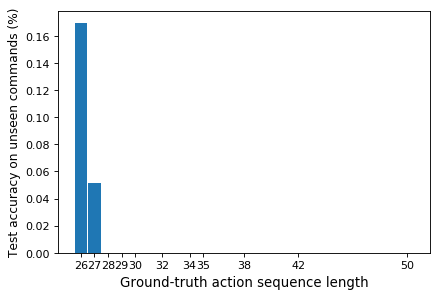

<Figure size 432x288 with 0 Axes>

In [41]:
act_lengths, act_accs = zip(*results_acts.items())
plt.figure(figsize=(6,4), dpi=80)
plt.bar(act_lengths, act_accs, width=0.9)
plt.xlabel('Ground-truth action sequence length', fontsize=12)
plt.ylabel('Test accuracy on unseen commands (%)', fontsize=11)
plt.xticks(ticks=act_lengths)
plt.savefig('./paper/plots/experiment_2_commands.png')
plt.show()
plt.clf()